In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ttest_ind

In [3]:
data = pd.read_csv('/Users/sheidamajidi/Desktop/Summer2024/MGSC670/G-HW2/energy_dataset.csv')

data = data.dropna(thresh=0.9*len(data), axis=1)
data.time = pd.to_datetime(data.time, utc = True, infer_datetime_format= True)
data['time'] = pd.to_datetime(data['time'])

/var/folders/zh/7hbjyl3x1y953yvj5t_7dbbw0000gn/T/ipykernel_8343/4167701360.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data.time = pd.to_datetime(data.time, utc = True, infer_datetime_format= True)


In [4]:
# focus on a specific period (January 2018) for one month testing
start_date = '2018-01-01'
end_date = '2018-02-01'
period_data = data[(data['time'] >= start_date) & (data['time'] < end_date)]

In [5]:
# feature engineering
period_data['hour'] = period_data['time'].dt.hour
period_data['dayofweek'] = period_data['time'].dt.dayofweek
period_data['month'] = period_data['time'].dt.month

# features and target for demand forecasting
features = period_data[['hour', 'dayofweek', 'month', 'price actual']]
target = period_data['total load actual']

# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

# train the demand forecasting model
model = RandomForestRegressor(n_estimators=100, random_state=123)
model.fit(X_train, y_train)

/var/folders/zh/7hbjyl3x1y953yvj5t_7dbbw0000gn/T/ipykernel_8343/2876799644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['hour'] = period_data['time'].dt.hour
/var/folders/zh/7hbjyl3x1y953yvj5t_7dbbw0000gn/T/ipykernel_8343/2876799644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['dayofweek'] = period_data['time'].dt.dayofweek
/var/folders/zh/7hbjyl3x1y953yvj5t_7dbbw0000gn/T/ipykernel_8343/2876799644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

RandomForestRegressor(random_state=42)

In [6]:
# predict demand
period_data['predicted_demand'] = model.predict(features)

/var/folders/zh/7hbjyl3x1y953yvj5t_7dbbw0000gn/T/ipykernel_8343/2882025413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['predicted_demand'] = model.predict(features)


### AB test: dynamic pricing implementation

In [7]:
# enhanced dynamic pricing
def enhanced_dynamic_pricing(demand, current_price, base_price=50, elasticity=0.2):
    return current_price + elasticity * (demand / demand.mean() - 1) * base_price

# apply enhanced dynamic pricing based on predicted demand and current price
period_data['enhanced_dynamic_price'] = enhanced_dynamic_pricing(
    period_data['predicted_demand'], period_data['price actual']
)


/var/folders/zh/7hbjyl3x1y953yvj5t_7dbbw0000gn/T/ipykernel_8343/569742430.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['enhanced_dynamic_price'] = enhanced_dynamic_pricing(


### Visualizing the results

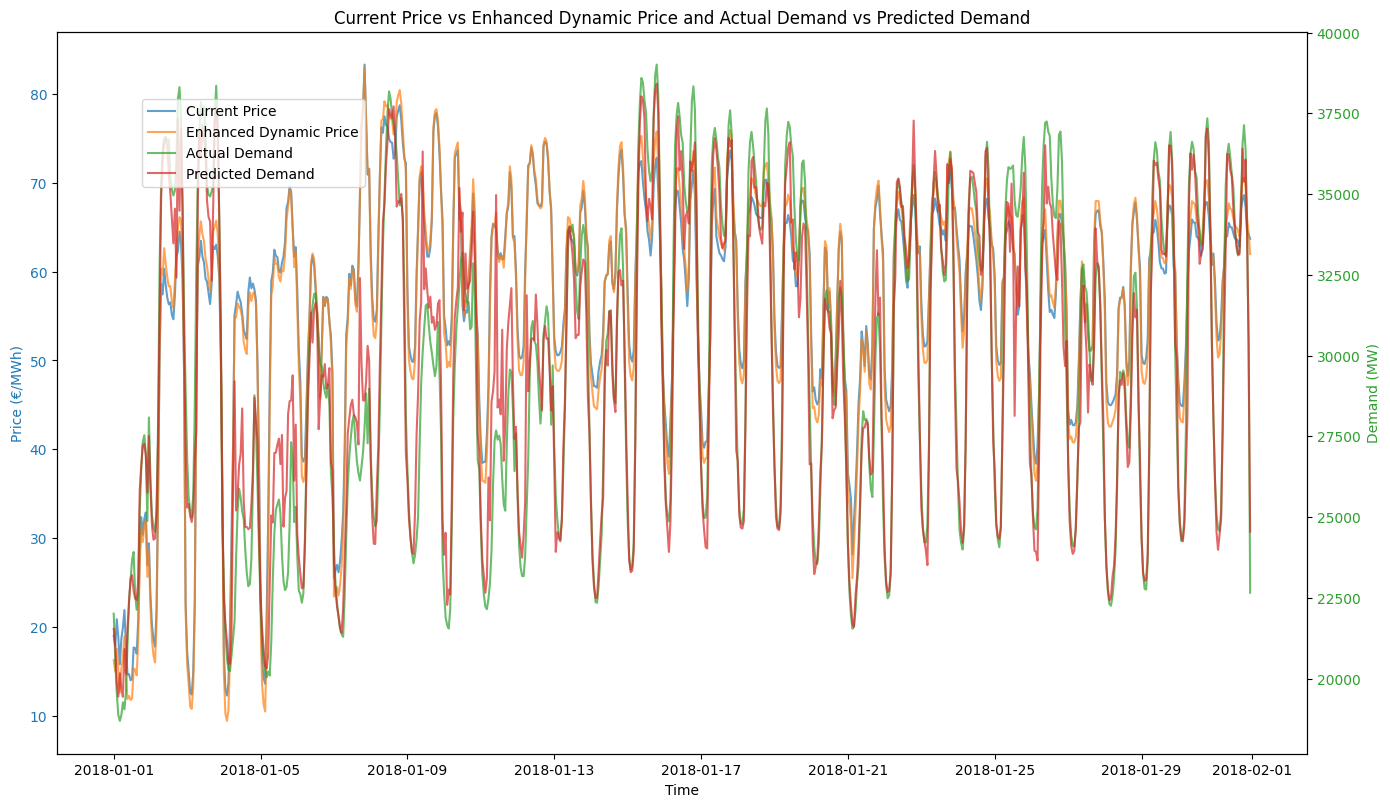

In [8]:
# actual demand, predicted demand, current price, and enhanced dynamic price
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Price (€/MWh)', color=color)
ax1.plot(period_data['time'], period_data['price actual'], color='tab:blue', label='Current Price', alpha=0.7)
ax1.plot(period_data['time'], period_data['enhanced_dynamic_price'], color='tab:orange', label='Enhanced Dynamic Price', alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Demand (MW)', color=color)
ax2.plot(period_data['time'], period_data['total load actual'], color='tab:green', label='Actual Demand', alpha=0.7)
ax2.plot(period_data['time'], period_data['predicted_demand'], color='tab:red', label='Predicted Demand', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Current Price vs Enhanced Dynamic Price and Actual Demand vs Predicted Demand')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

In [9]:
# total revenue for control (current pricing) and test (enhanced pricing) groups
control_revenue = (period_data['price actual'] * period_data['total load actual']).sum()
test_revenue = (period_data['enhanced_dynamic_price'] * period_data['total load actual']).sum()

print(f"Total Revenue (Control Group - Current Pricing): €{control_revenue:.2f}")
print(f"Total Revenue (Test Group - Enhanced Pricing): €{test_revenue:.2f}")


Total Revenue (Control Group - Current Pricing): €1282437850.54
Total Revenue (Test Group - Enhanced Pricing): €1288043724.76


In [10]:
# statistical test to determine significance
# revenues per hour
control_revenues = period_data['price actual'] * period_data['total load actual']
test_revenues = period_data['enhanced_dynamic_price'] * period_data['total load actual']

# t-test
t_stat, p_value = ttest_ind(control_revenues, test_revenues)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.2f}")

if p_value < 0.05:
    print("The difference in revenue is statistically significant.")
else:
    print("The difference in revenue is not statistically significant.")

T-statistic: -0.24, P-value: 0.81
The difference in revenue is not statistically significant.
